In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nflreadpy as nfl
from plotting_functions import draw_position_of_last_frame

In [2]:
input_files = [f'Data/input_2023_w{i:02}.csv' for i in range(1, 19)]
inputs = pd.concat([pd.read_csv(file) for file in input_files], ignore_index=True)
input_players = inputs[['player_name', 'player_position']].drop_duplicates()

# make plays that are going left go right instead
going_left = inputs['play_direction'] == 'left'
inputs.loc[going_left, 'x'] = 120 - inputs.loc[going_left, 'x']
inputs.loc[going_left, 'y'] = 53.3 - inputs.loc[going_left, 'y']
inputs.loc[going_left, 'ball_land_x'] = 120 - inputs.loc[going_left, 'ball_land_x']
inputs.loc[going_left, 'ball_land_y'] = 53.3 - inputs.loc[going_left, 'ball_land_y']
inputs.loc[going_left, 'o'] = (180 + inputs.loc[going_left, 'o']) % 360
inputs.loc[going_left, 'dir'] = (180 + inputs.loc[going_left, 'dir']) % 360

# Do we need outputs?
#output_files = [f'Data/output_2023_w{i:02}.csv' for i in range(1, 19)]
#outputs = pd.concat([pd.read_csv(file) for file in output_files], ignore_index=True)

players = pd.DataFrame(nfl.load_players()[['gsis_id', 'display_name']])
players.columns = ['player_id', 'player_name']
player_crosswalk = pd.merge(players, inputs[['player_name', 'player_position', 'nfl_id']].drop_duplicates(), on = 'player_name', how = 'inner')

pbp_data = pd.read_parquet('Data/play_by_play_2023.parquet')
pbp_data = pbp_data[['play_id', 'old_game_id', 
                 'epa', 'qb_hit', 'pass_defense_1_player_id', 'pass_defense_1_player_name', 
                 'pass_defense_2_player_id', 'pass_defense_2_player_name',
                 'interception_player_id', 'interception_player_name',
                 'cp', 'xpass']]
pbp_data['play_id'] = pbp_data['play_id'].astype(int)
pbp_data['game_id'] = pbp_data['old_game_id'].astype(int)

pass_deflections = pbp_data[pd.notna(pbp_data['pass_defense_1_player_id']) | pd.notna(pbp_data['pass_defense_2_player_id'])]
pass_deflections['pass_deflection'] = 1
pass_deflections['num_deflections'] = np.where(pass_deflections['pass_defense_2_player_id'].isna(), 1, 2)
pass_deflections = pd.merge(pass_deflections, player_crosswalk, left_on = 'pass_defense_1_player_id', right_on = 'player_id', how = 'left')

interceptions = pbp_data[pd.notna(pbp_data['interception_player_id'])]
interceptions['interception'] = 1
interceptions = pd.merge(interceptions, player_crosswalk, left_on = 'interception_player_id', right_on = 'player_id', how = 'left')
supplementary_data = pd.read_csv('Data/supplementary_data.csv')
valid_plays = supplementary_data[supplementary_data['season'] == 2023]
valid_plays = pd.merge(valid_plays, pbp_data, on=['game_id', 'play_id'], how='inner')
valid_plays['interception'] = np.where(valid_plays['pass_result'] == 'IN', 1, 0)
valid_plays = pd.merge(valid_plays, pass_deflections[['game_id', 'play_id', 'pass_deflection', 'player_position']], on=['game_id', 'play_id'], how='left')
valid_plays['pass_deflection'] = valid_plays['pass_deflection'].fillna(0)
valid_plays = valid_plays[valid_plays.team_coverage_man_zone == 'ZONE_COVERAGE']
valid_plays = valid_plays[valid_plays.pass_length > 5]

C:\Users\jerem\AppData\Local\Temp\ipykernel_13844\1289781589.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_deflections['pass_deflection'] = 1
C:\Users\jerem\AppData\Local\Temp\ipykernel_13844\1289781589.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_deflections['num_deflections'] = np.where(pass_deflections['pass_defense_2_player_id'].isna(), 1, 2)
C:\Users\jerem\AppData\Local\Temp\ipykernel_13844\1289781589.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [3]:
all_pd = pass_deflections[['game_id', 'play_id', 'nfl_id', 'pass_deflection', 'num_deflections']]
all_pd = all_pd.dropna()
all_pd['pd_id'] = all_pd['nfl_id'].astype('int')
all_pd = all_pd.drop('nfl_id', axis=1)

all_int = interceptions[['game_id', 'play_id', 'nfl_id', 'interception']]
all_int = all_int.dropna()
all_int['int_id'] = all_int['nfl_id'].astype('int')
all_int = all_int.drop('nfl_id', axis=1)

pd_or_int = all_pd.merge(all_int, on = ['game_id', 'play_id'], how = 'left')
pd_or_int.loc[pd_or_int['pd_id'] == pd_or_int['int_id'], 'pass_deflection'] = 0
int_plays = pd_or_int[pd_or_int['interception'] == 1]
int_plays['nfl_id'] = int_plays['int_id']

C:\Users\jerem\AppData\Local\Temp\ipykernel_13844\1389070672.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_plays['nfl_id'] = int_plays['int_id']


In [62]:
# get all lurkers
last_frame = inputs.loc[inputs.groupby(['game_id', 'play_id'])['frame_id'].transform('max') == inputs['frame_id']].reset_index(drop=True)

targets = last_frame[last_frame['player_role'] == 'Targeted Receiver'][['game_id', 'play_id', 'x', 'y']]
targets = targets.rename(columns={'x': 'target_x', 'y': 'target_y'})

# Step 2: merge back to all rows
last_frame = last_frame.merge(targets, on=['game_id', 'play_id'], how='inner')

# keep defenders whose x is less than target
last_frame = last_frame[last_frame['player_role'] == 'Defensive Coverage']
last_frame = last_frame[last_frame['x'] < last_frame['target_x']]

# distance to target
last_frame['distance_to_target'] = np.sqrt(
    (last_frame['target_x'] - last_frame['x'])**2 + (last_frame['target_y'] - last_frame['y'])**2
)
# distance to ball
last_frame['distance_to_ball'] = np.sqrt(
    (last_frame['ball_land_x'] - last_frame['x'])**2 + (last_frame['ball_land_y'] - last_frame['y'])**2
)
# depth difference
last_frame['depth_difference'] = last_frame['target_x'] - last_frame['x']

#last_frame.loc[(last_frame['distance_'] < last_frame['target_x']) & (last_frame['player_role'] == 'Defensive Coverage'), 'player_role'] = 'Potential Lurker'

last_frame.loc[(last_frame['distance_to_target'] < 8) & (last_frame['player_role'] == 'Defensive Coverage'), 'player_role'] = 'Potential Lurker'
last_frame.loc[(last_frame['distance_to_ball'] < 8) & (last_frame['player_role'] == 'Defensive Coverage'), 'player_role'] = 'Potential Lurker'

In [5]:
#lurker_deflections = last_frame.merge(all_pd, on = ['game_id', 'play_id', 'nfl_id'], how = 'inner')
lurker_interceptions = last_frame.merge(int_plays, on = ['game_id', 'play_id', 'nfl_id'], how = 'inner')
lurker_interceptions_no_pd = lurker_interceptions[lurker_interceptions['num_deflections'] == 1]

In [6]:
# quay walker = distance to ball 3 yard, came from other side.... VALID LURK PLAY EXAMPLE
# rudy ford = distance to ball 5 yards, came from other side.... VALID LURK PLAY EXAMPLE

lurker_int_no_pd_more_info = lurker_interceptions_no_pd.merge(supplementary_data, on = ['game_id', 'play_id'], how = 'left')
lurker_int_no_pd_more_info = lurker_int_no_pd_more_info[lurker_int_no_pd_more_info.team_coverage_man_zone == 'ZONE_COVERAGE']
lurker_int_no_pd_more_info = lurker_int_no_pd_more_info[lurker_int_no_pd_more_info.route_of_targeted_receiver != 'GO']
lurker_int_no_pd_more_info = lurker_int_no_pd_more_info[lurker_int_no_pd_more_info.pass_length >= 5]
lurker_int_no_pd_more_info = lurker_int_no_pd_more_info[lurker_int_no_pd_more_info.pass_length <= 30]

In [8]:
#https://youtu.be/Cn_1B9tuLhk?t=154
lurker_int_no_pd_more_info[lurker_int_no_pd_more_info['pass_length'] == 26][['week', 'home_team_abbr', 'visitor_team_abbr', 'quarter', 'play_description', 'distance_to_target', 'distance_to_ball', 'depth_difference']]

,week,home_team_abbr,visitor_team_abbr,quarter,play_description,distance_to_target,distance_to_ball,depth_difference
32,7,NYG,WAS,2,(9:43) (Shotgun) S.Howell pass deep left inten...,11.640812,10.669739,3.78


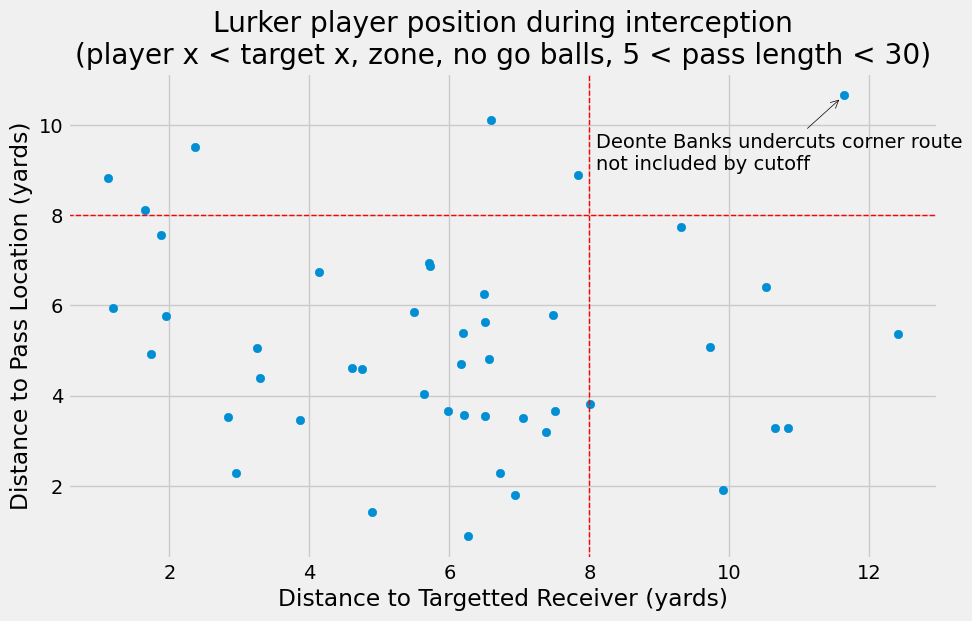

In [59]:
plt.figure(figsize=(10, 6))
plt.style.use("fivethirtyeight")
plt.scatter(lurker_int_no_pd_more_info.distance_to_target, lurker_int_no_pd_more_info.distance_to_ball)
plt.xlabel('Distance to Targetted Receiver (yards)')
plt.ylabel('Distance to Pass Location (yards)')
plt.annotate('Deonte Banks undercuts corner route\nnot included by cutoff', xytext = (8.1, 9), xy = (11.6, 10.6), arrowprops=dict(color = 'black', arrowstyle="->", connectionstyle="arc3"))
plt.title('Lurker player position during interception\n(player x < target x, zone, no go balls, 5 < pass length < 30)')
plt.axhline(y=8, linestyle = '--', linewidth = 1, color = 'red')
plt.axvline(x=8, linestyle = '--', linewidth = 1, color = 'red')

,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
1487,2023091711,2023,2,09/17/2023,16:25:00,DEN,WAS,3920,(5:51) (Shotgun) R.Wilson pass incomplete shor...,4,...,COVER_2_ZONE,NaN,0,0,1.779928,-0.512756,0.081174,0.918826,-0.009403,0.009403


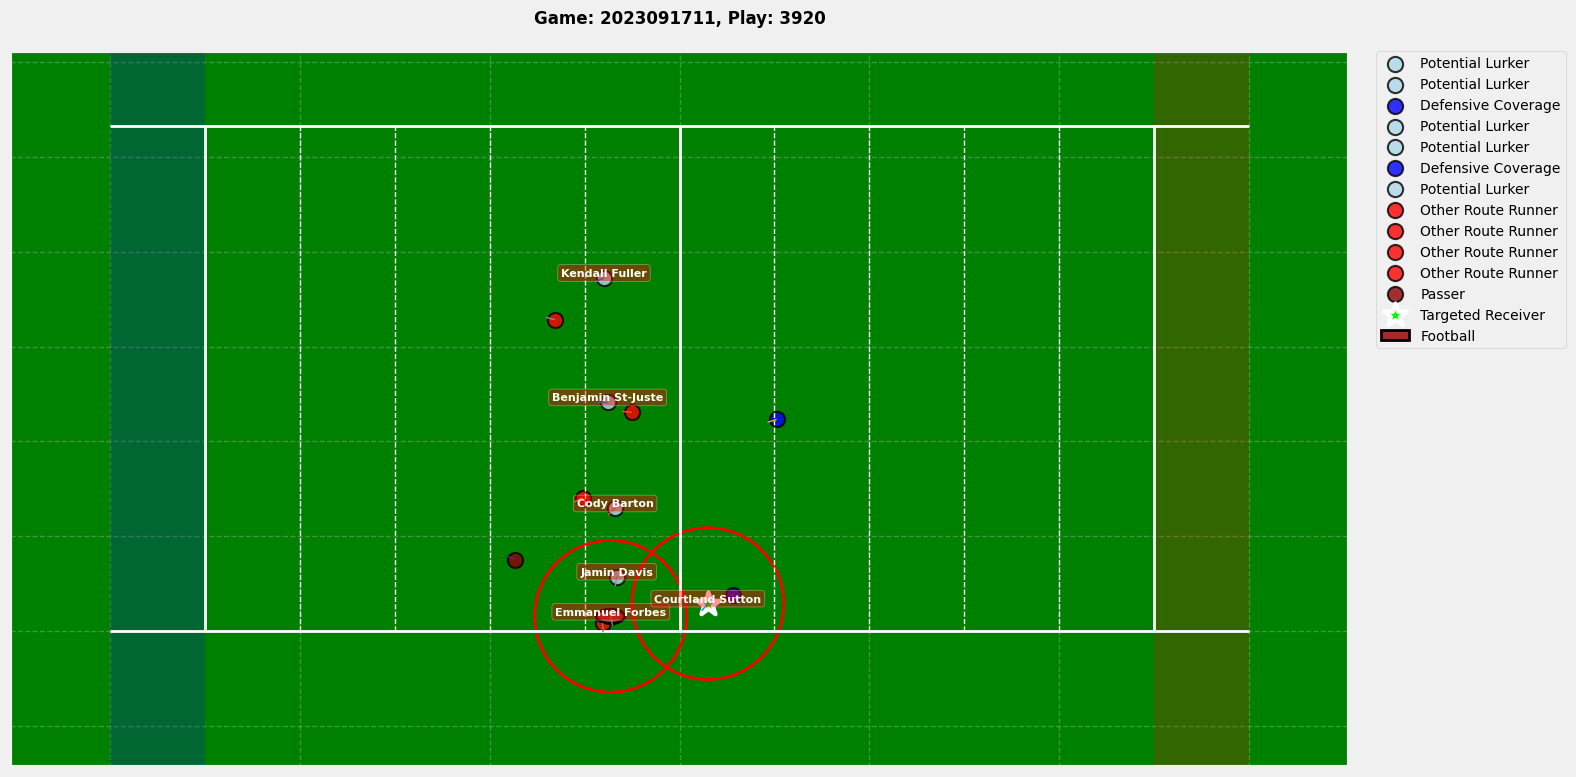

In [87]:
game_id = 2023091711
play_id = 3920
frame_id = inputs[(inputs['game_id'] == game_id) & (inputs['play_id'] == play_id)]['frame_id'].values[-1]
test_positions = inputs[(inputs['game_id'] == game_id) & (inputs['play_id'] == play_id) & (inputs['frame_id'] == frame_id)]
draw_position_of_last_frame(test_positions, 8)
supplementary_data[(supplementary_data['game_id'] == game_id) & (supplementary_data['play_id'] == play_id)]

In [114]:
valid_plays = last_frame.merge(supplementary_data, on = ['game_id', 'play_id'], how = 'left')
valid_plays = valid_plays[valid_plays.team_coverage_man_zone == 'ZONE_COVERAGE'] 
# remove coverage = prevent, or win percentage crazy?
valid_plays = valid_plays[valid_plays.route_of_targeted_receiver != 'GO']
valid_plays = valid_plays[valid_plays.pass_length >= 5]
valid_plays = valid_plays[valid_plays.pass_length <= 30]
potential_lurkers = valid_plays[valid_plays['player_role'] == 'Potential Lurker']
lurkers_per_play = potential_lurkers.groupby(['game_id', 'play_id']).size().reset_index(name='counts')
# 3607 potential lurkers out of 11832 players, on 2585 plays
# 272 games 

In [118]:
potential_lurkers[potential_lurkers.depth_difference > 10]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
2657,2023091711,3920,True,55880,49,right,45,Emmanuel Forbes,6-0,180,...,COVER_2_ZONE,NaN,0,0,1.779928,-0.512756,0.081174,0.918826,-0.009403,0.009403
2667,2023091711,4471,True,52624,40,right,18,Kam Curl,6-2,203,...,COVER_4_ZONE,NaN,12,12,0.097030,0.224133,0.013950,0.986050,0.003373,-0.003373
3428,2023092404,3516,True,54540,51,left,85,Christian Harris,6-2,232,...,COVER_3_ZONE,NaN,13,13,1.688197,0.663114,0.046738,0.953262,0.001899,-0.001899
9856,2023102900,3139,True,55945,35,left,77,DJ Johnson,6-4,270,...,COVER_3_ZONE,NaN,0,0,1.277899,-0.866144,0.338626,0.661374,0.034691,-0.034691
10681,2023102909,553,True,44974,59,right,69,Anthony Walker,6-1,230,...,COVER_3_ZONE,NaN,17,17,3.450268,1.144796,0.819581,0.180419,0.024116,-0.024116
20825,2023122100,161,True,53532,39,left,60,Ernest Jones,6-2,230,...,COVER_3_ZONE,NaN,16,16,3.102619,0.874117,0.509339,0.490661,-0.014318,0.014318


In [86]:
lurkers_per_play.counts.value_counts()

counts
1    3588
2    1279
3     241
4      39
5       1
Name: count, dtype: int64

(array([2.535e+03, 1.580e+03, 1.206e+03, 8.620e+02, 5.650e+02, 2.370e+02,
        3.300e+01, 8.000e+00, 3.000e+00, 1.000e+00]),
 array([1.0000e-02, 1.4050e+00, 2.8000e+00, 4.1950e+00, 5.5900e+00,
        6.9850e+00, 8.3800e+00, 9.7750e+00, 1.1170e+01, 1.2565e+01,
        1.3960e+01]),
 <BarContainer object of 10 artists>)

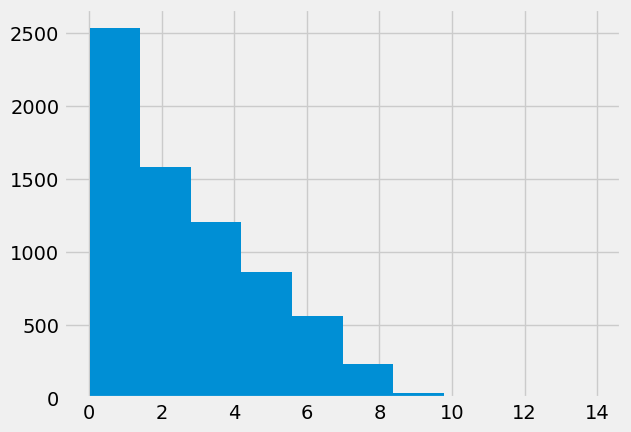

In [90]:
plt.hist(potential_lurkers['depth_difference'])

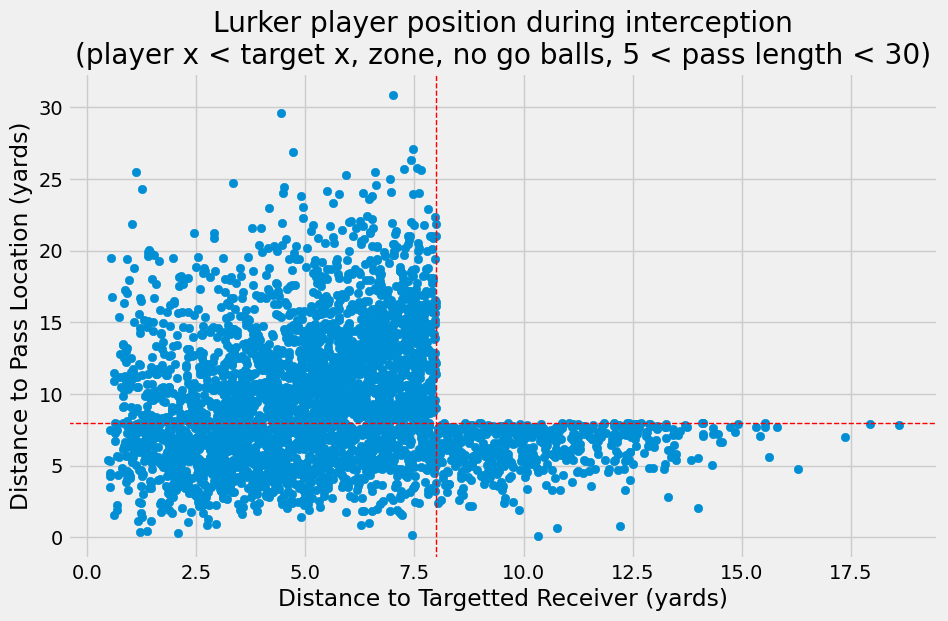

In [162]:
plt.figure(figsize=(10, 6))
plt.style.use("fivethirtyeight")
plt.scatter(potential_lurkers.distance_to_target, potential_lurkers.distance_to_ball)
plt.xlabel('Distance to Targetted Receiver (yards)')
plt.ylabel('Distance to Pass Location (yards)')
plt.title('Lurker player position during interception\n(player x < target x, zone, no go balls, 5 < pass length < 30)')
plt.axhline(y=8, linestyle = '--', linewidth = 1, color = 'red')
plt.axvline(x=8, linestyle = '--', linewidth = 1, color = 'red')

In [172]:
potential_lurkers[potential_lurkers.distance_to_ball > 20]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
773,2023091007,2160,False,49410,32,left,73,Jalen Thompson,5-11,190,...,COVER_6_ZONE,NaN,0,0,1.006721,-0.267631,0.540021,0.459979,-0.004757,0.004757
775,2023091007,2160,False,56045,32,left,73,Kei'Trel Clark,5-10,177,...,COVER_6_ZONE,NaN,0,0,1.006721,-0.267631,0.540021,0.459979,-0.004757,0.004757
1201,2023091011,3491,True,46194,30,right,72,Avonte Maddox,5-9,184,...,COVER_6_ZONE,NaN,0,0,3.781825,-0.555020,0.237654,0.762346,-0.015849,0.015849
1326,2023091012,3618,True,47891,39,left,50,Julian Love,5-11,193,...,COVER_2_ZONE,NaN,0,0,3.363996,-0.440318,0.019793,0.980207,0.000956,-0.000956
1441,2023091100,3167,True,46190,26,left,33,Taron Johnson,5-11,192,...,COVER_2_ZONE,NaN,14,14,3.702493,1.617919,0.264906,0.735094,0.080036,-0.080036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24384,2024010707,1205,True,55149,32,left,65,Markquese Bell,6-3,205,...,COVER_3_ZONE,NaN,0,0,2.646747,-0.489401,0.212406,0.787594,-0.012722,0.012722
24385,2024010707,1205,True,38540,32,left,65,Stephon Gilmore,6-1,202,...,COVER_3_ZONE,NaN,0,0,2.646747,-0.489401,0.212406,0.787594,-0.012722,0.012722
24554,2024010709,1752,True,56265,29,right,71,Cam Jones,6-3,228,...,COVER_2_ZONE,NaN,0,0,2.818885,-0.703895,0.303371,0.696629,-0.015896,0.015896
24635,2024010710,1596,False,46157,24,right,56,Oren Burks,6-3,233,...,COVER_2_ZONE,NaN,0,0,1.581198,-1.534465,0.770460,0.229540,0.030321,-0.030321


In [181]:
potential_lurkers[potential_lurkers.distance_to_target > 15]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
4065,2023092411,1860,True,47913,29,right,35,Drue Tranquill,6-2,234,...,COVER_2_ZONE,NaN,0,0,0.679354,-4.511905,0.990183,0.009817,0.005503,-0.005503
9856,2023102900,3139,True,55945,35,left,77,DJ Johnson,6-4,270,...,COVER_3_ZONE,NaN,0,0,1.277899,-0.866144,0.338626,0.661374,0.034691,-0.034691
11805,2023110505,3607,True,46132,46,right,99,Carlton Davis III,6-1,206,...,COVER_4_ZONE,NaN,0,0,3.498344,-0.656665,0.667131,0.332869,-0.045610,0.045610
15709,2023112601,1030,False,43503,24,right,63,Elandon Roberts,6-0,238,...,COVER_3_ZONE,NaN,31,31,2.923465,2.086289,0.539554,0.460446,0.052853,-0.052853
16447,2023112609,5183,True,44911,32,left,73,Rasul Douglas,6-2,209,...,COVER_4_ZONE,NaN,17,17,1.207627,1.341627,0.373788,0.626212,0.106287,-0.106287
18418,2023121004,1153,True,54533,40,left,76,Martin Emerson,6-2,200,...,COVER_6_ZONE,NaN,0,0,0.370407,-1.527352,0.726495,0.273505,0.023200,-0.023200
20777,2023121801,3350,True,38577,22,right,35,Bobby Wagner,6-0,242,...,COVER_3_ZONE,NaN,15,15,1.696632,0.592411,0.189773,0.810227,-0.021421,0.021421
20825,2023122100,161,True,53532,39,left,60,Ernest Jones,6-2,230,...,COVER_3_ZONE,NaN,16,16,3.102619,0.874117,0.509339,0.490661,-0.014318,0.014318
22479,2023123000,1471,True,55149,31,left,15,Markquese Bell,6-3,205,...,COVER_3_ZONE,NaN,0,0,5.398423,-1.072747,0.552809,0.447191,0.038676,-0.038676
23817,2024010601,2866,True,47947,40,right,77,E.J. Speed,6-4,230,...,COVER_3_ZONE,NaN,0,0,3.399449,-1.477846,0.357568,0.642432,0.037402,-0.037402


,game_id,season,week,game_date,game_time_eastern,home_team_abbr,visitor_team_abbr,play_id,play_description,quarter,...,team_coverage_type,penalty_yards,pre_penalty_yards_gained,yards_gained,expected_points,expected_points_added,pre_snap_home_team_win_probability,pre_snap_visitor_team_win_probability,home_team_win_probability_added,visitor_team_win_probility_added
9267,2023112609,2023,12,11/26/2023,16:25:00,PHI,BUF,5183,(4:27) (Shotgun) J.Hurts pass deep left to D.S...,5,...,COVER_4_ZONE,NaN,17,17,1.207627,1.341627,0.373788,0.626212,0.106287,-0.106287


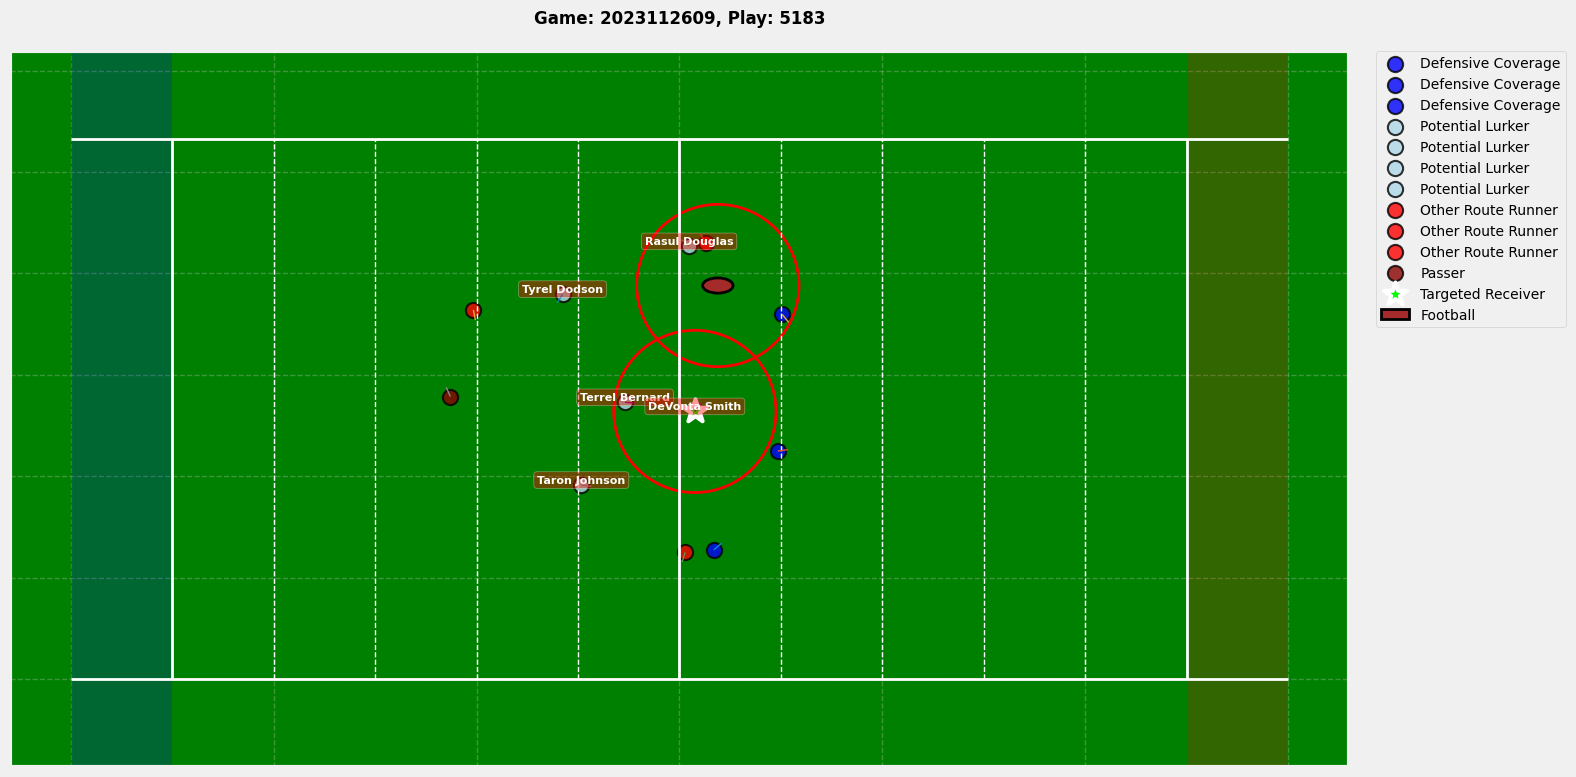

In [184]:
game_id = 2023112609
play_id = 5183
frame_id = inputs[(inputs['game_id'] == game_id) & (inputs['play_id'] == play_id)]['frame_id'].values[-1]
test_positions = inputs[(inputs['game_id'] == game_id) & (inputs['play_id'] == play_id) & (inputs['frame_id'] == frame_id)]
draw_position_of_last_frame(test_positions, 8)
supplementary_data[(supplementary_data['game_id'] == game_id) & (supplementary_data['play_id'] == play_id)]

In [176]:
supplementary_data[(supplementary_data['game_id'] == game_id) & (supplementary_data['play_id'] == play_id)]['route_of_targeted_receiver'].values

array(['CORNER'], dtype=object)

In [139]:
potential_lurkers.player_name.value_counts()

player_name
T.J. Edwards            43
Kenny Moore II          39
Devin Lloyd             38
Kenneth Murray, Jr.     36
Alex Singleton          32
                        ..
C.J. Gardner-Johnson     1
Sean Chandler            1
Joshua Williams          1
Nic Jones                1
Logan Ryan               1
Name: count, Length: 531, dtype: int64

In [161]:
potential_lurkers.groupby(['player_name']).size()[potential_lurkers.groupby(['player_name']).size() >= 20]

player_name
Alex Anzalone          28
Alex Singleton         32
Bobby Okereke          24
Bobby Wagner           31
Brian Branch           23
C.J. Mosley            21
Christian Harris       23
Christian Izien        20
De'Vondre Campbell     21
Demario Davis          26
Denzel Perryman        21
Devin Lloyd            38
Devin White            20
Divine Deablo          20
Dre Greenlaw           31
E.J. Speed             21
Eric Kendricks         32
Ernest Jones           21
Foye Oluokun           31
Frankie Luvu           27
Fred Warner            25
Germaine Pratt         22
Jordan Hicks           22
Jordyn Brooks          23
Josey Jewell           24
Kaden Elliss           22
Keisean Nixon          23
Kenneth Murray, Jr.    36
Kenny Moore II         39
Kyler Gordon           21
Kyzir White            21
Lavonte David          31
Logan Wilson           28
Micah McFadden         20
Nicholas Morrow        26
Patrick Queen          32
Quay Walker            27
Quincy Williams        27


In [150]:
potential_lurkers.player_position.value_counts()

player_position
CB     1013
ILB     766
OLB     576
MLB     519
FS      337
SS      293
DE       71
DT       15
S        11
NT        6
Name: count, dtype: int64

In [143]:
potential_lurkers.route_of_targeted_receiver.value_counts()

route_of_targeted_receiver
HITCH     778
IN        717
POST      567
OUT       472
CROSS     454
CORNER    368
SLANT     211
FLAT       17
WHEEL      13
ANGLE       8
SCREEN      2
Name: count, dtype: int64

In [148]:
potential_lurkers.team_coverage_type.value_counts()

team_coverage_type
COVER_3_ZONE    1663
COVER_4_ZONE     766
COVER_2_ZONE     646
COVER_6_ZONE     521
PREVENT           11
Name: count, dtype: int64

In [141]:
potential_lurkers.columns

Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y',
       'target_x', 'target_y', 'distance_to_target', 'distance_to_ball',
       'depth_difference', 'season', 'week', 'game_date', 'game_time_eastern',
       'home_team_abbr', 'visitor_team_abbr', 'play_description', 'quarter',
       'game_clock', 'down', 'yards_to_go', 'possession_team',
       'defensive_team', 'yardline_side', 'yardline_number',
       'pre_snap_home_score', 'pre_snap_visitor_score',
       'play_nullified_by_penalty', 'pass_result', 'pass_length',
       'offense_formation', 'receiver_alignment', 'route_of_targeted_receiver',
       'play_action', 'dropback_type', 'dropback_distance',
       'pass_location_type', 'defende